In [1]:
# Import all your required libraries
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

In [3]:
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [4]:
# Read Data into a Pandas DataFrame
data = pd.read_csv('Data/creditcard.csv',sep=',')

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# The class text field above denotes whether the transaction is Fraud or Not. 0 - Normal, 1 - Fraud.
# Let's check if there are any null Values. 
data.isnull().values.any()

False

Text(0.5, 0, 'Class')

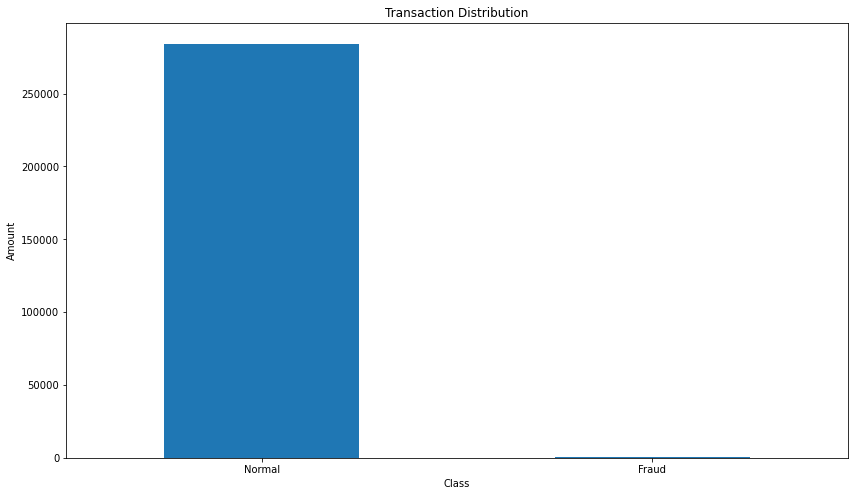

In [7]:
# Let's plot the class values on a bar chart
class_values = pd.value_counts(data['Class'], sort = True)
class_values.plot(kind = 'bar', rot=0)

plt.title("Transaction Distribution")
plt.xticks(range(2), LABELS)
plt.ylabel("Amount")
plt.xlabel("Class")

In [8]:
# As you can see from the graph above, the number of fraud transactions is very low compared to normal
# Now let's get the fraud and normal classes into different dataframes
normal = data[data['Class']==0]
fraud = data[data['Class']==1]

In [9]:
# Let's see if the amount of money used in different transaction classes is different
# Maybe we can observe a few trends
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [11]:
# We can see that the average amount of a fraud transaction is slightly higher than a normal one
# This doesn't tell us much 
# Now let's clean our data and prepare it for passing it to our model.

#Create independent and Dependent Features
columns = data.columns.tolist()

# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]

# Now we store the variable we are predicting 
target = "Class"

# Define a random state 
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


In [12]:
## Now, it's time to build our model. We'll be using two different anomaly detection algorithms to identify the
# anomalies in our data.
"""
Isolation Forest Algorithm :

The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature. Isolating anomaly 
observations is easier because only a few conditions are needed to separate those cases from the normal observations. 
On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as 
the number of conditions required to separate a given observation. The way that the algorithm constructs the separation is by 
first creating isolation trees, or random decision trees.

Local Outlier Factor(LOF) Algorithm : 

The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point 
with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

"""

'\nIsolation Forest Algorithm :\n\nThe Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting \na split value between the maximum and minimum values of the selected feature. Isolating anomaly \nobservations is easier because only a few conditions are needed to separate those cases from the normal observations. \nOn the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as \nthe number of conditions required to separate a given observation. The way that the algorithm constructs the separation is by \nfirst creating isolation trees, or random decision trees.\n\nLocal Outlier Factor(LOF) Algorithm : \n\nThe LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point \nwith respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.\n\n'

In [15]:
# Now let's define the outlier detection methods
outlier_fraction = len(fraud)/float(len(normal))
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction)
   
}


In [16]:
# Set Number of outliers to length of our fraud data set 
n_outliers = len(fraud)

for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 675
Accuracy Score :
0.9976299739823811
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.31      0.32      0.31       492

    accuracy                           1.00    284807
   macro avg       0.66      0.66      0.66    284807
weighted avg       1.00      1.00      1.00    284807

Local Outlier Factor: 935
Accuracy Score :
0.9967170750718908
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.05      0.05       492

    accuracy                           1.00    284807
   macro avg       0.52      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807



In [18]:
# Observations :
# Isolation Forest detected 675 errors versus Local Outlier Factor detecting 935 errors.
# Isolation Forest is 99.74% accurate and LOF is 99.67% accurate.
# When comparing error precision & recall for the 2 models , the Isolation Forest performed much better than the LOF
# as we can see that the detection of fraud cases is around 32 % versus LOF detection rate of just 5 %.
# So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
# We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.
# We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases